## NREL National Solar Radiation Database (NSRDB) - HSDS Demo

This notebook demonstrates basic usage of the National Renewable Energy Laboratory (NREL) National Solar Radiation Database (NSRDB) data. The data is provided from Amazon Web Services using the HDF Group's Highly Scalable Data Service (HSDS).

For this to work you must first install h5pyd:

```
pip install --user h5pyd
```

Next you'll need to configure HSDS:

```
hsconfigure
```

and enter at the prompt:

```
hs_endpoint = https://developer.nrel.gov/api/hsds
hs_username = None
hs_password = None
hs_api_key = CLN7qg8PRpaqkkeS9STW3BvCMvh81m4UYopmVoOf
```

You can also add the above contents to a configuration file at ~/.hscfg

In [40]:
%matplotlib inline
import h5pyd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy.spatial import cKDTree

## Basic Usage

The NSRDB is provided in annual .h5 files and currently spans 1998-2018.  
Each year can be accessed from /nrel/nsrdb/nsrdb_${year}.h5

In [41]:
# Open the desired year of nsrdb data
# server endpoint, username, password is found via a config file
f = h5pyd.File("/nrel/nsrdb/v3/nsrdb_2020.h5", 'r')

In [42]:
list(f.attrs)  # list attributes belonging to the root group

['version']

In [43]:
f.attrs['version']   # attributes can be used to provide desriptions of the content

'3.2.0'

In [44]:
list(f['wind_speed'].attrs)

['data_source',
 'elevation_correction',
 'physical_max',
 'physical_min',
 'psm_scale_factor',
 'psm_units',
 'scale_factor',
 'spatial_interp_method',
 'temporal_interp_method',
 'units']

## Datasets

In [45]:
list(f)  # list the datasets in the file

['air_temperature',
 'alpha',
 'aod',
 'asymmetry',
 'cld_opd_dcomp',
 'cld_reff_dcomp',
 'clearsky_dhi',
 'clearsky_dni',
 'clearsky_ghi',
 'cloud_press_acha',
 'cloud_type',
 'coordinates',
 'dew_point',
 'dhi',
 'dni',
 'fill_flag',
 'ghi',
 'meta',
 'ozone',
 'relative_humidity',
 'solar_zenith_angle',
 'ssa',
 'surface_albedo',
 'surface_pressure',
 'time_index',
 'total_precipitable_water',
 'wind_direction',
 'wind_speed']

In [46]:
# Datasets are stored in a 2d array of time x location
dset = f['wind_speed']
dset.shape

(17568, 2018392)

In [47]:
# Extract datetime index for datasets
time_index = pd.to_datetime(f['time_index'][...].astype(str))
time_index # Temporal resolution is 30min

DatetimeIndex(['2020-01-01 00:00:00+00:00', '2020-01-01 00:30:00+00:00',
               '2020-01-01 01:00:00+00:00', '2020-01-01 01:30:00+00:00',
               '2020-01-01 02:00:00+00:00', '2020-01-01 02:30:00+00:00',
               '2020-01-01 03:00:00+00:00', '2020-01-01 03:30:00+00:00',
               '2020-01-01 04:00:00+00:00', '2020-01-01 04:30:00+00:00',
               ...
               '2020-12-31 19:00:00+00:00', '2020-12-31 19:30:00+00:00',
               '2020-12-31 20:00:00+00:00', '2020-12-31 20:30:00+00:00',
               '2020-12-31 21:00:00+00:00', '2020-12-31 21:30:00+00:00',
               '2020-12-31 22:00:00+00:00', '2020-12-31 22:30:00+00:00',
               '2020-12-31 23:00:00+00:00', '2020-12-31 23:30:00+00:00'],
              dtype='datetime64[ns, UTC]', length=17568, freq=None)

In [48]:
# Locational information is stored in either 'meta' or 'coordinates'
meta = pd.DataFrame(f['meta'][...])
meta.head()

,latitude,longitude,elevation,timezone,country,state,county,urban,population,landcover
0,-19.99,-175.259995,0.0,13,b'None',b'None',b'None',b'None',-9999,210
1,-19.99,-175.220001,0.0,13,b'None',b'None',b'None',b'None',-9999,210
2,-19.99,-175.179993,0.0,13,b'None',b'None',b'None',b'None',-9999,210
3,-19.99,-175.139999,0.0,13,b'None',b'None',b'None',b'None',-9999,210
4,-19.99,-175.100006,0.0,13,b'None',b'None',b'None',b'None',-9999,210


In [49]:
meta[meta.state == b'Texas']

,latitude,longitude,elevation,timezone,country,state,county,urban,population,landcover
57215,30.690001,-105.019997,1023.320007,-7,b'United States',b'Texas',b'Hudspeth',b'None',0,130
57471,30.730000,-105.099998,972.687500,-6,b'United States',b'Texas',b'Hudspeth',b'None',3,130
57472,30.730000,-105.059998,1005.700012,-7,b'United States',b'Texas',b'Hudspeth',b'None',0,130
57473,30.730000,-105.019997,1158.300049,-7,b'United States',b'Texas',b'Hudspeth',b'None',0,130
57730,30.770000,-105.139999,989.080017,-7,b'United States',b'Texas',b'Hudspeth',b'None',0,130
...,...,...,...,...,...,...,...,...,...,...
771633,31.090000,-93.580002,50.119999,-6,b'United States',b'Texas',b'Newton',b'None',12,50
771685,31.129999,-93.580002,54.400002,-6,b'United States',b'Texas',b'Newton',b'None',4,50
771702,30.889999,-93.580002,42.880001,-6,b'United States',b'Texas',b'Newton',b'None',1,50
771773,31.049999,-93.580002,58.680000,-6,b'United States',b'Texas',b'Newton',b'None',89,50


In [50]:
# Datasets have been saved as integers
dset.dtype

dtype('uint16')

In [51]:
# To convert dataset values back to floats use the 'psm_scale_factor'
dset.attrs['psm_scale_factor'] # Irradiance values have been truncated to integer precision

10.0

In [52]:
# wind speed on the other hand has single decimal percision when scaled by 10
scale_factor = f['wind_speed'].attrs['psm_scale_factor']
units = f['wind_speed'].attrs['psm_units']
print('wind_speed scale factor = ', scale_factor)
# print('wind_speed units after unscaling = ', units)
f['wind_speed'][0, 0] / scale_factor # divide by scale_factor to return native value

wind_speed scale factor =  10.0


9.7

In [53]:
f['wind_speed'][:, 0] / scale_factor

array([9.7, 9.6, 9.5, ..., 6.7, 6.8, 6.8])

Get the time_index from the server and convert to a pandas DatetimeIndex for convenience:

In [54]:
time_index = pd.to_datetime(f['time_index'][...].astype(str))
time_index

DatetimeIndex(['2020-01-01 00:00:00+00:00', '2020-01-01 00:30:00+00:00',
               '2020-01-01 01:00:00+00:00', '2020-01-01 01:30:00+00:00',
               '2020-01-01 02:00:00+00:00', '2020-01-01 02:30:00+00:00',
               '2020-01-01 03:00:00+00:00', '2020-01-01 03:30:00+00:00',
               '2020-01-01 04:00:00+00:00', '2020-01-01 04:30:00+00:00',
               ...
               '2020-12-31 19:00:00+00:00', '2020-12-31 19:30:00+00:00',
               '2020-12-31 20:00:00+00:00', '2020-12-31 20:30:00+00:00',
               '2020-12-31 21:00:00+00:00', '2020-12-31 21:30:00+00:00',
               '2020-12-31 22:00:00+00:00', '2020-12-31 22:30:00+00:00',
               '2020-12-31 23:00:00+00:00', '2020-12-31 23:30:00+00:00'],
              dtype='datetime64[ns, UTC]', length=17568, freq=None)

Extract indexes for a particular span of time:

## Wind Data

In [55]:
# Full resolution subset of Colorado
#meta = pd.DataFrame(f['meta'][...])
Texas = meta.loc[meta['state'] == b'Texas'] # Note .h5 saves strings as bit-strings
Texas.head()

,latitude,longitude,elevation,timezone,country,state,county,urban,population,landcover
57215,30.690001,-105.019997,1023.320007,-7,b'United States',b'Texas',b'Hudspeth',b'None',0,130
57471,30.730000,-105.099998,972.687500,-6,b'United States',b'Texas',b'Hudspeth',b'None',3,130
57472,30.730000,-105.059998,1005.700012,-7,b'United States',b'Texas',b'Hudspeth',b'None',0,130
57473,30.730000,-105.019997,1158.300049,-7,b'United States',b'Texas',b'Hudspeth',b'None',0,130
57730,30.770000,-105.139999,989.080017,-7,b'United States',b'Texas',b'Hudspeth',b'None',0,130


In [56]:
# Filter to only some samples in the panhandle
sampled_index = Texas.loc[(Texas['latitude'] > 31.9) & (Texas['longitude'] < -99.9)].index

# Filter a bit more because this is still too many samples to pull.
sampled_index = [a for a in sampled_index if a % 3 == 0]
len(sampled_index)

3055

In [57]:
dataset_name = 'wind_speed'

dset = f[dataset_name]

slice_step = 200

data = dset[0::slice_step, sampled_index]
df = pd.DataFrame(index=time_index[0::slice_step], data=data, columns=sampled_index)
df = df.loc[df.index.minute == 0]

In [58]:
df.index.min()

Timestamp('2020-01-01 00:00:00+0000', tz='UTC')

In [59]:
df.index.max()

Timestamp('2020-12-28 12:00:00+0000', tz='UTC')

In [60]:
for key, val in dset.attrs.items():
    print(key, val)

data_source MERRA2
elevation_correction False
physical_max 40.0
physical_min 0.0
psm_scale_factor 10.0
psm_units m/s
scale_factor 10.0
spatial_interp_method IDW4
temporal_interp_method linear
units m/s


In [61]:
df.melt()['value'].describe()

count    268840.000000
mean         36.502831
std          17.353606
min           1.000000
25%          23.000000
50%          35.000000
75%          49.000000
max          92.000000
Name: value, dtype: float64

In [62]:
df = df/dset.attrs['scale_factor']

In [63]:
df.melt()['value'].describe()

count    268840.000000
mean          3.650283
std           1.735361
min           0.100000
25%           2.300000
50%           3.500000
75%           4.900000
max           9.200000
Name: value, dtype: float64

**Note the 75th percentile wind speed above! That's crazy low. That's like 10% of a GE 2.5 MW turbine's rated power.**

We wouldn't have turbines in the panhandle if this were true. Compare to: https://windexchange.energy.gov/maps-data/232

In [64]:
coords = f['coordinates']
coord_data = coords[Texas.index, :]

coord_df = pd.DataFrame(index=Texas.index, data=coord_data, columns=['lat', 'lon'])
coord_df.head(3)

,lat,lon
57215,30.690001,-105.019997
57471,30.730000,-105.099998
57472,30.730000,-105.059998


In [65]:
lat_mapper = coord_df['lat'].to_dict()
lon_mapper = coord_df['lon'].to_dict()

In [66]:
wind_speed_melt = df.melt()

In [67]:
wind_speed_melt['latitude'] = wind_speed_melt['variable'].map(lat_mapper)
wind_speed_melt['longitude'] = wind_speed_melt['variable'].map(lon_mapper)

In [68]:
wind_speed_melt

,variable,value,latitude,longitude
0,65931,1.4,31.930000,-106.620003
1,65931,0.8,31.930000,-106.620003
2,65931,1.7,31.930000,-106.620003
3,65931,1.9,31.930000,-106.620003
4,65931,2.6,31.930000,-106.620003
...,...,...,...,...
268835,618117,4.2,34.049999,-99.940002
268836,618117,4.4,34.049999,-99.940002
268837,618117,1.3,34.049999,-99.940002
268838,618117,3.1,34.049999,-99.940002


In [69]:
wind_speed_melt['value'].describe()

count    268840.000000
mean          3.650283
std           1.735361
min           0.100000
25%           2.300000
50%           3.500000
75%           4.900000
max           9.200000
Name: value, dtype: float64

<Axes: xlabel='longitude', ylabel='latitude'>

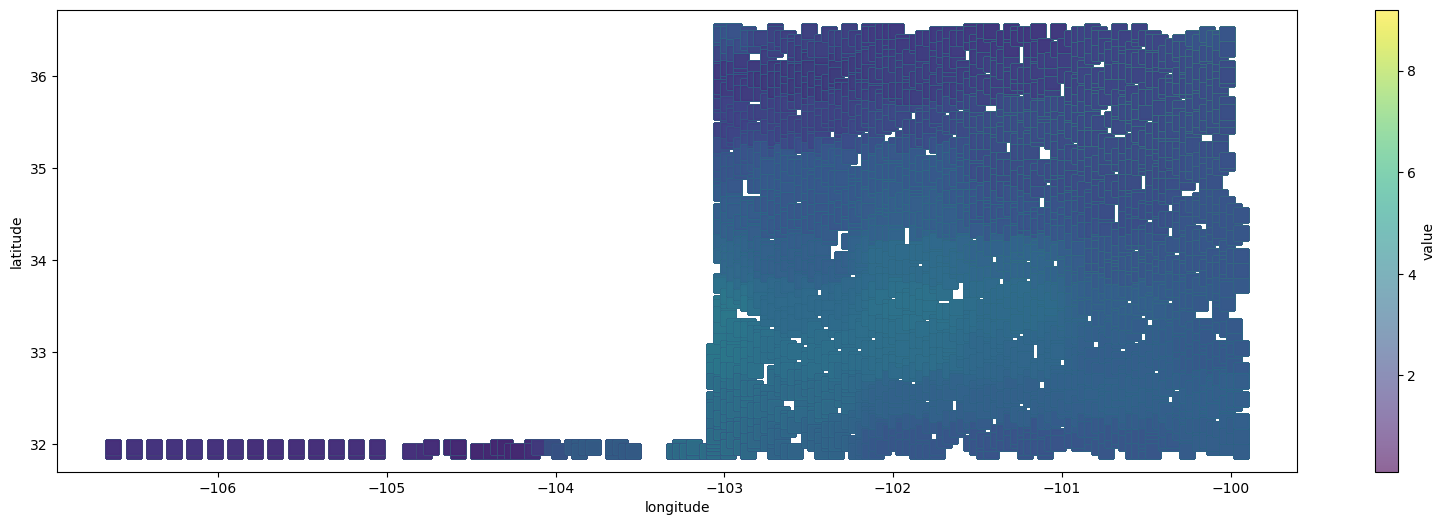

In [70]:
fig, ax = plt.subplots(figsize=(20, 6))

wind_speed_melt.plot.scatter('longitude', 'latitude', c='value', s=100, alpha=0.6, ax=ax, marker='s')

In [71]:
from functools import partial

power_curve = {
    3: 25,
    3.5: 89, 
    4: 171, 
    4.5: 269, 
    5: 389,
    5.5: 533,
    6: 704,
    6.5: 906,
    7: 1136,
    7.5: 1400,
    8: 1674,
    8.5: 1934,
    9: 2160,
    9.5: 2316,
    10: 2416, 
    10.5: 2477,
    11: 2514,
    12: 2530, 
    12.5: 2530, 
    25: 2530,
}

power_curve_key = np.array(list(power_curve.keys()))
power_curve_val = np.array(list(power_curve.values()))

power_curve_function = partial(np.interp, xp=power_curve_key, fp=power_curve_val, left=0, right=0)

power_curve_function(3.8)

138.19999999999996

In [72]:
wind_speed_melt['power'] = wind_speed_melt['value'].map(power_curve_function)

In [73]:
wind_speed_melt['capacity_factor'] = wind_speed_melt['power']/2.5e3

In [74]:
wind_speed_melt['capacity_factor'].describe()

count    268840.000000
mean          0.097949
std           0.138846
min           0.000000
25%           0.000000
50%           0.035600
75%           0.146000
max           0.888960
Name: capacity_factor, dtype: float64

<Axes: xlabel='longitude', ylabel='latitude'>

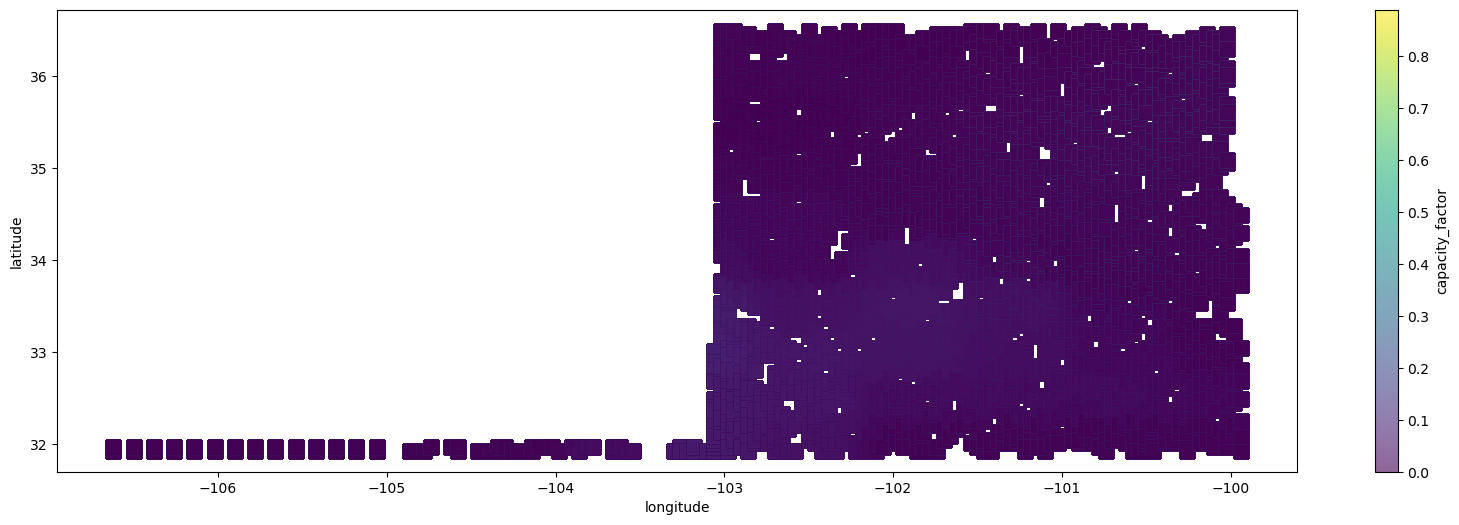

In [75]:
fig, ax = plt.subplots(figsize=(20, 6))

wind_speed_melt.plot.scatter('longitude', 'latitude', c='capacity_factor', s=100, alpha=0.6, ax=ax, marker='s')

<Axes: xlabel='longitude', ylabel='latitude'>

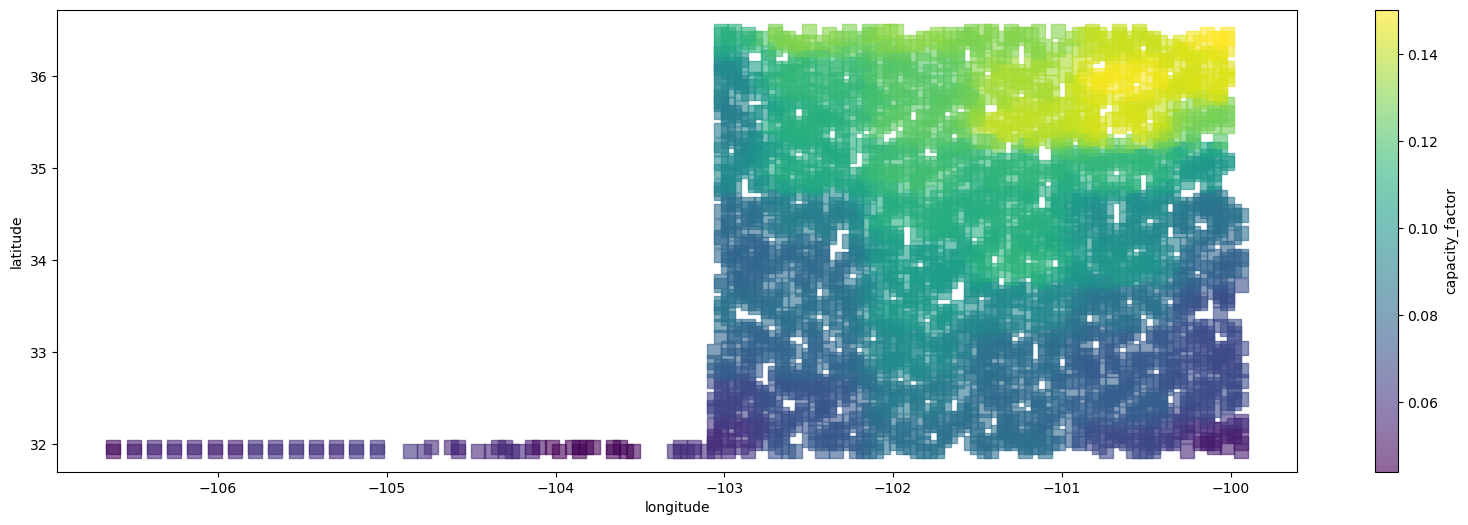

In [76]:
mean_capacity_factor = wind_speed_melt.groupby(by=['latitude', 'longitude']).agg({'capacity_factor': 'mean'}).reset_index()

fig, ax = plt.subplots(figsize=(20, 6))

mean_capacity_factor.plot.scatter('longitude', 'latitude', c='capacity_factor', s=100, alpha=0.6, ax=ax, marker='s')

In [77]:
wind_speed_melt

,variable,value,latitude,longitude,power,capacity_factor
0,65931,1.4,31.930000,-106.620003,0.0,0.00000
1,65931,0.8,31.930000,-106.620003,0.0,0.00000
2,65931,1.7,31.930000,-106.620003,0.0,0.00000
3,65931,1.9,31.930000,-106.620003,0.0,0.00000
4,65931,2.6,31.930000,-106.620003,0.0,0.00000
...,...,...,...,...,...,...
268835,618117,4.2,34.049999,-99.940002,210.2,0.08408
268836,618117,4.4,34.049999,-99.940002,249.4,0.09976
268837,618117,1.3,34.049999,-99.940002,0.0,0.00000
268838,618117,3.1,34.049999,-99.940002,37.8,0.01512


<Axes: xlabel='longitude', ylabel='latitude'>

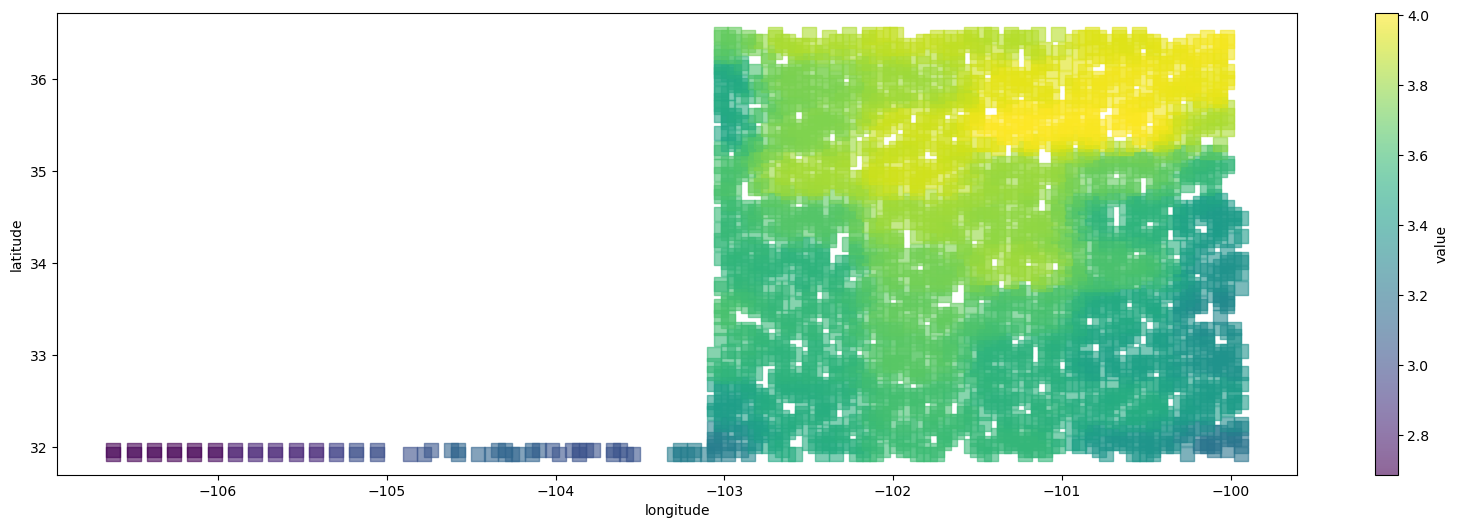

In [78]:
mean_wind_speed = wind_speed_melt.groupby(by=['latitude', 'longitude']).agg({'value': 'mean'}).reset_index()

fig, ax = plt.subplots(figsize=(20, 6))

mean_wind_speed.plot.scatter('longitude', 'latitude', c='value', s=100, alpha=0.6, ax=ax, marker='s')